In [132]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
from scipy import optimize
from autograd import grad

In [133]:
## NEURON PARAMTERS
tau = 10.
eta_0 = 0.1
tau_adapt = 10.
rho_0 = 0.1
v = 0
delta_u = 1.
mu_M = 1e-6
mu_Q = 1e-6
tau_G = 10.
tau_baseline = 100.
dt = 1.

In [134]:
## NETWORK PARAMTERS
num_visible = 30
num_hidden = 50
num_neurons = num_visible + num_hidden
num_timebins = 5000

In [135]:
## INITIALIZE WEIGHTS
weights_M = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(weights_M, 0)

weights_Q = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(weights_Q, 0)

# no connections from visible->visible or hidden->visible in Q weights (top half of matrix)
weights_Q[:num_visible, :] = 0

In [136]:
# INITIALIZE NETWORK RUN
phi = np.zeros(shape = (num_neurons, num_timebins))
rho = np.zeros(shape = (num_neurons, num_timebins))
eta = np.zeros(shape = (num_neurons, num_timebins))
u = np.zeros(shape = (num_neurons, num_timebins))
spikes = np.zeros(shape = (num_neurons, num_timebins))
spike_probs = np.zeros(shape = (num_neurons, num_timebins))

# phi[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
phi[:, 0] = np.zeros(num_neurons)
# eta[:, 0] = np.random.normal(loc = 0.0, scale = 0.1, size = num_neurons)
eta[:, 0] = np.zeros(num_neurons)
u[:, 0] = np.matmul(weights_M, phi[:, 0]) - eta[:, 0]
rho[:, 0] = rho_0 * np.exp(u[:, 0])
spike_probs[:, 0] = 1-np.exp(-rho[:, 0])
spikes[:, 0] = np.random.binomial(n = 1, p = spike_probs[:, 0])

In [137]:
## GENERATE RANDOM SPIKES
for tt in range(1, num_timebins):
    
    # changes in potential
    dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])

    phi[:, tt] = phi[:, tt - 1] + dphi
    eta[:, tt] = eta[:, tt - 1] + deta
    
    # potential is weighted sum
    total_potential = np.matmul(weights_M, phi[:, tt]) - eta_0 * eta[:, tt]
    u[:, tt] = total_potential
    
    # firiing intensity
    rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)

    # generate spikes randomly as in paper
    spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])
    spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])

In [138]:
## GENERATE STAIRCASE PATTERN
neuron_block_size = np.floor(num_visible / 3)
curr_neuron_block = 0
interval_idx = 0
timebin_counter = 0

# intervals for length of "stairs"
gaussian_intervals = np.random.normal(size = 100, loc=100, scale=30).astype(int)

spikes[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), 0] = 1

# simulate network
for tt in range(1, num_timebins):
    
    # changes in potential
    dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])

    phi[:, tt] = phi[:, tt - 1] + dphi
    eta[:, tt] = eta[:, tt - 1] + deta

    total_potential = np.matmul(weights_M, phi[:, tt]) - eta_0 * eta[:, tt]
    u[:, tt] = total_potential

    # firing intensity
    rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)
    
    # increase intensity of current stair neurons
    rho[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] += 4.0
    
    # decrease intensity of non-stair neurons
    nonblock_idx = np.delete(np.arange(num_visible), np.arange(int(curr_neuron_block * neuron_block_size), int((curr_neuron_block + 1) * neuron_block_size)))
    rho[nonblock_idx, tt] = 0.05

    # generate spikes randomly as in paper
    spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])
    spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])
        
    # which neurons are the new stairs?
    timebin_counter += 1
    if timebin_counter == gaussian_intervals[interval_idx]:
        interval_idx += 1
        timebin_counter = 0
        if curr_neuron_block < 2:
            curr_neuron_block += 1
        else:
            curr_neuron_block = 0

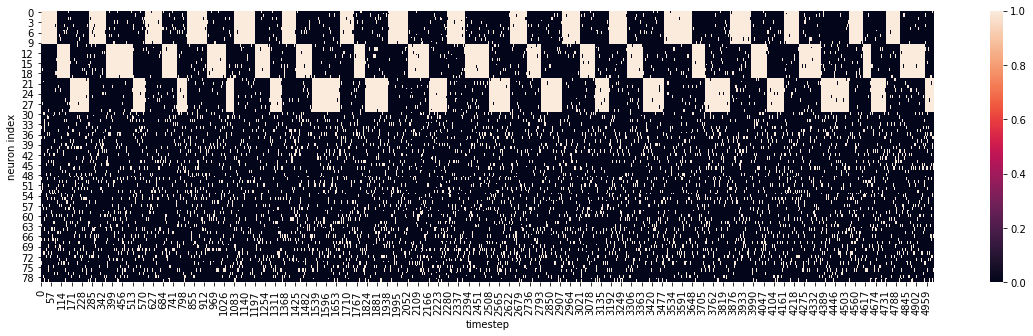

In [139]:
## HEATMAP OF GENERATED SPIKES
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(spikes)
plt.xlabel("timestep")
plt.ylabel("neuron index")
plt.show()

In [140]:
## FUNCTIONS FOR M AND Q LIKELIHOODS AND THEIR GRADIENTS

import autograd.numpy as np

## Likelihood of M network
def LL_M(curr_weights):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, phi) - eta_0 * eta

    curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
#     curr_rho[num_visible:, :] = rho[num_visible:, :]#.copy() # set hidden rho to the values determined by Q network 
                                                               # (NOTE: this doesn't work in autograd, so I switched 
                                                               # to computing the M gradient by hand)

    LL = np.sum(np.multiply(np.log(curr_rho), spikes) - curr_rho) * dt
    return -LL

# Data log-likelihood
def data_log_likelihood(curr_weights):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, phi) - eta_0 * eta

    curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
    individual_likelihoods = np.multiply(np.log(curr_rho), spikes) - curr_rho
    LL = np.sum(individual_likelihoods[:num_visible, :]) * dt
    return LL

# M gradient by hand
def LL_M_gradient_by_hand(curr_weights):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, phi) - eta_0 * eta

    curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
    curr_rho[num_visible:, :] = rho_Q[num_visible:, :].copy() # set hidden rho to the values determined by Q network
    phi[num_visible:, :] = phi_Q[num_visible:, :].copy() 
    
    spike_intensity_diff = spikes - curr_rho
    M_grad = -np.matmul(spike_intensity_diff, phi.T) * dt
    return M_grad


## Likelihood of Q network (only sums over hidden neurons)
def LL_Q(curr_weights):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, phi_Q) - eta_0 * eta_Q

    curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
    individual_likelihoods = np.multiply(np.log(curr_rho), spikes_Q) - curr_rho
    LL = np.sum(individual_likelihoods[num_visible:, :]) * dt # only sum over hidden
    return -LL

# Q gradient by hand
def LL_Q_gradient_by_hand(curr_weights):
    # make sure weights are shaped correctly
    curr_weights = np.reshape(curr_weights, [num_neurons, num_neurons])

    total_potential = np.matmul(curr_weights, phi_Q) - eta_0 * eta_Q

    curr_rho = rho_0 * np.exp((total_potential - v) / delta_u)
    spike_intensity_diff = spikes_Q - curr_rho
    Q_grad = -np.matmul(spike_intensity_diff, phi_Q.T) * dt
    return Q_grad


In [141]:
# GRADIENTS COURTESY OF AUTOGRAD
grad_LL_M = grad(LL_M)
grad_LL_Q = grad(LL_Q)

In [142]:
# INITIALIZE WEIGHTS FOR LEARNING
learned_weights_M = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(learned_weights_M, 0)

learned_weights_Q = np.random.normal(loc = 0, scale = 0.1, size = (num_neurons, num_neurons))
np.fill_diagonal(learned_weights_Q, 0)

In [143]:
# VALUES TO STORE OVER TRAINING
free_energy_trace = []
mean_subtract_free_energy_trace = []
LL_M_trace = []
LL_Q_trace = []

In [144]:
# LEARNING PARAMETERS
num_iters = 1000
variance_reduction_window = 10 # window of past free energies to average and subtract (reduces gradient variance)

In [145]:
## TRAINING

for iter_num in range(num_iters):

    ## GET READY TO SIMULATE Q NETWORK
    phi_Q = phi.copy() #np.zeros(shape = (num_neurons, num_timebins))
    rho_Q = rho.copy() #np.zeros(shape = (num_neurons, num_timebins))
    eta_Q = eta.copy() #np.zeros(shape = (num_neurons, num_timebins))
    u_Q = u #np.zeros(shape = (num_neurons, num_timebins))
    spikes_Q = np.zeros(shape = (num_neurons, num_timebins))
    spike_probs_Q = np.zeros(shape = (num_neurons, num_timebins))

    spike_probs_Q[:, 0] = 1-np.exp(-rho_Q[:, 0])
    spikes_Q[:, 0] = np.random.binomial(n = 1, p = spike_probs_Q[:, 0])
    spikes_Q[:num_visible, :] = spikes[:num_visible, :].copy()


    ## SIMULATE Q FOR 1,...T TO GET HIDDEN NEURONS' SPIKES
    for tt in range(1, num_timebins):

        dphi = dt * (1 / tau) * (spikes_Q[:, tt - 1] - phi_Q[:, tt - 1])
        deta = dt * (1 / tau_adapt) * (spikes_Q[:, tt - 1] - eta_Q[:, tt - 1])

        phi_Q[:, tt] = phi_Q[:, tt - 1] + dphi
        eta_Q[:, tt] = eta_Q[:, tt - 1] + deta

        total_potential = np.matmul(learned_weights_Q, phi_Q[:, tt]) - eta_0 * eta_Q[:, tt]
        u_Q[:, tt] = total_potential

        rho_Q[:, tt] = rho_0 * np.exp((u_Q[:, tt] - v) / delta_u)

        spike_probs_Q[:, tt] = 1-np.exp(-dt*rho_Q[:, tt])
        spikes_Q[:, tt] = np.random.binomial(n = 1, p = spike_probs_Q[:, tt])
        
    # Spikes of visibles are always determined by the data
    spikes_Q[:num_visible, :] = spikes[:num_visible, :].copy()

    # Set hidden neuron activity to be those just simulated from Q network
    spikes[num_visible:, :] = spikes_Q[num_visible:, :].copy()
    phi[num_visible:, :] = phi_Q[num_visible:, :].copy()
    rho[num_visible:, :] = rho_Q[num_visible:, :].copy()
    eta[num_visible:, :] = eta_Q[num_visible:, :].copy()
    u[num_visible:, :] = u_Q[num_visible:, :].copy()
    spike_probs[num_visible:, :] = spike_probs_Q[num_visible:, :].copy()

    # DATA LOG LIKELIHOOD
    curr_data_LL = data_log_likelihood(learned_weights_M)
    
    ## M likelihood
    curr_LL_M = LL_M(learned_weights_M)
    LL_M_trace.append(curr_LL_M)
    
    # M gradient
    M_weights_gradients = grad_LL_M(learned_weights_M)
#     M_weights_gradients = LL_M_gradient_by_hand(learned_weights_M)
    
    # update M weights
    learned_weights_M -= mu_M * M_weights_gradients

    # Q likelihood
    curr_LL_Q = LL_Q(learned_weights_Q)
    LL_Q_trace.append(curr_LL_Q)
    
    # Q gradient
    Q_weights_gradients = grad_LL_Q(learned_weights_Q)
#     Q_weights_gradients = LL_Q_gradient_by_hand(learned_weights_Q)
    
    # Calculate point estimate of free energy
    free_energy = curr_LL_Q - curr_LL_M
    free_energy_trace.append(free_energy)

    # Variance reduction technique from paper (mean-subtract free energy)
    if iter_num == 0:
        curr_free_energy = 1
    else:
        curr_window_start_idx = max(-variance_reduction_window, -len(free_energy_trace))
        curr_free_energy = free_energy - np.mean(free_energy_trace[curr_window_start_idx:])
        mean_subtract_free_energy_trace.append(curr_free_energy)

    # update Q weights
    learned_weights_Q -= mu_Q * Q_weights_gradients * curr_free_energy

    # reset connections to visible to 0
    learned_weights_Q[:num_visible, :] = 0
    
    # reset self-connections to 0
    np.fill_diagonal(learned_weights_Q, 0)
    
    # print progress
    if iter_num % 50 == 0:
        print 'iter: {}, M: {}, Q: {}, Data LL: {}'.format(iter_num, curr_LL_M, curr_LL_Q, curr_data_LL)
        

iter: 0, M: 224872.309667, Q: 79352.4992082, Data LL: -144086.929253
iter: 50, M: 177909.342797, Q: 55109.828083, Data LL: -119675.174911
iter: 100, M: 153385.452575, Q: 48460.8699364, Data LL: -101102.230144
iter: 150, M: 137711.773778, Q: 44972.2477262, Data LL: -88836.530403
iter: 200, M: 129367.84764, Q: 43564.9493737, Data LL: -82143.0576281
iter: 250, M: 125823.973094, Q: 43479.4571755, Data LL: -79136.9269472
iter: 300, M: 123747.259803, Q: 43051.0177177, Data LL: -77900.8025985
iter: 350, M: 123034.327871, Q: 43103.4484124, Data LL: -77416.8438186
iter: 400, M: 121839.764769, Q: 42354.5267853, Data LL: -77153.6291153
iter: 450, M: 121352.185337, Q: 42249.2882274, Data LL: -76989.6592837
iter: 500, M: 121232.615638, Q: 42570.5400476, Data LL: -76840.7305268
iter: 550, M: 120706.621839, Q: 42299.9574872, Data LL: -76746.9486711
iter: 600, M: 120466.986437, Q: 42344.7117082, Data LL: -76644.0166025
iter: 650, M: 120271.545078, Q: 42403.3740848, Data LL: -76551.9810389
iter: 700, M

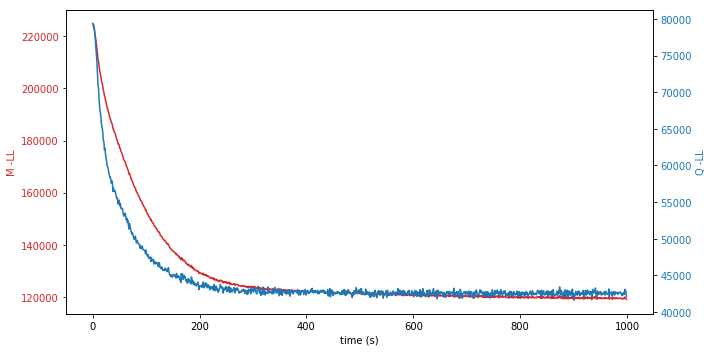

In [146]:
## PLOT LOSS OVER TIME
fig, ax1 = plt.subplots(figsize = (10, 5))

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('M -LL', color=color)
ax1.plot(LL_M_trace, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Q -LL', color=color)  # we already handled the x-label with ax1
ax2.plot(LL_Q_trace, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


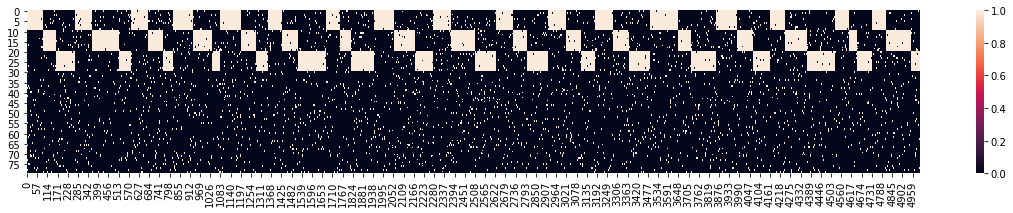

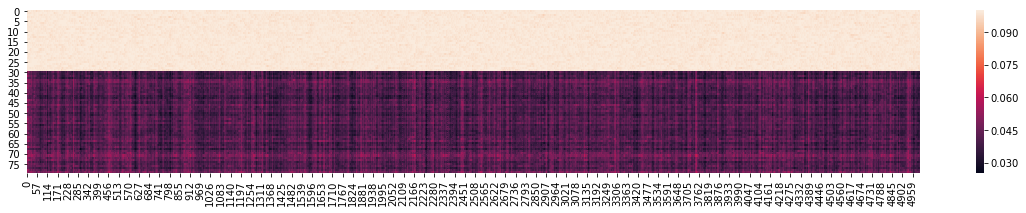

In [147]:
## HEATMAP Q SPIKES AND FIRING INTENSITIES
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spikes_Q)
plt.title("Spikes")
plt.show()

fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(rho_Q)
plt.title("Firing intensities")
plt.show()

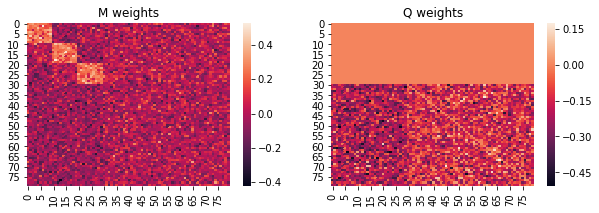

In [148]:
## HEATMAP LEARNED WEIGHTS
f = plt.figure(figsize=(10, 3))
f.add_subplot(121)
plt.title("M weights")
sns.heatmap(learned_weights_M)
f.add_subplot(122)
sns.heatmap(learned_weights_Q)
plt.title("Q weights")
plt.show()

In [149]:
## SIMULATE LEARNED M NETWORK
curr_neuron_block = 0
# spikes[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), 0] = 1

for tt in range(1, num_timebins):
        
        
    dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])

    phi[:, tt] = phi[:, tt - 1] + dphi
    eta[:, tt] = eta[:, tt - 1] + deta

    total_potential = np.matmul(learned_weights_M, phi[:, tt]) - eta_0 * eta[:, tt]
    u[:, tt] = total_potential + 1

    rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)

#         spikes[:, tt] = np.random.poisson(rho[:, tt])
    spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])
    spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])

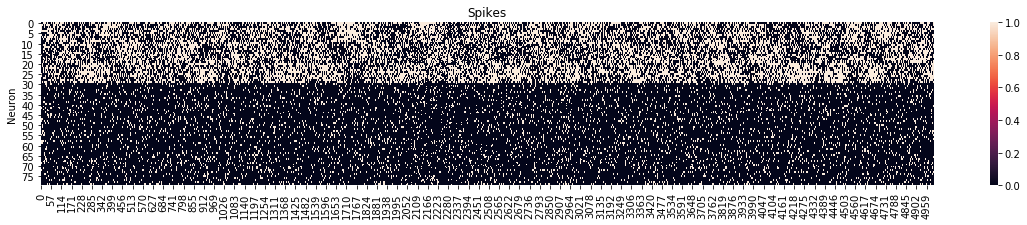

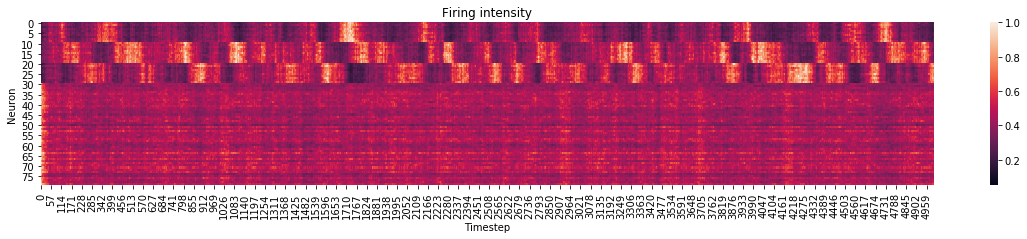

In [150]:
## HEATMAP SIMULATED M NETWORK
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spikes) #, xticklabels=False, yticklabels=False)
plt.ylabel("Neuron")
plt.title("Spikes")
plt.show()

# fig, ax = plt.subplots(figsize=(20, 3))
# sns.heatmap(rho[num_visible:])
# plt.show()

row_sums = np.max(rho, axis=1) #rho.sum(axis=1)
rho_row_normalized = rho / row_sums[:, np.newaxis]

fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(rho_row_normalized) #, xticklabels=False, yticklabels=False)
plt.title("Firing intensity")
plt.xlabel("Timestep")
plt.ylabel("Neuron")
plt.show()

In [151]:
## staircase pattern
neuron_block_size = np.floor(num_visible / 3)
curr_neuron_block = 0
interval_idx = 0
timebin_counter = 0

spikes[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), 0] = 1

    
for tt in range(1, num_timebins):
                
    dphi = dt * (1 / tau) * (spikes[:, tt - 1] - phi[:, tt - 1])
    deta = dt * (1 / tau_adapt) * (spikes[:, tt - 1] - eta[:, tt - 1])

    phi[:, tt] = phi[:, tt - 1] + dphi
    eta[:, tt] = eta[:, tt - 1] + deta

    total_potential = np.matmul(learned_weights_Q, phi[:, tt]) - eta_0 * eta[:, tt]
    u[:, tt] = total_potential

    rho[:, tt] = rho_0 * np.exp((u[:, tt] - v) / delta_u)
    
    rho[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] += 1.0
    
    rho[int(curr_neuron_block * neuron_block_size):int((curr_neuron_block + 1) * neuron_block_size), tt] += 1.0
    nonblock_idx = np.delete(np.arange(num_visible), np.arange(int(curr_neuron_block * neuron_block_size), int((curr_neuron_block + 1) * neuron_block_size)))
    rho[nonblock_idx, tt] = 0.05


#         spikes[:, tt] = np.random.poisson(rho[:, tt])
    spike_probs[:, tt] = 1-np.exp(-dt*rho[:, tt])
    spikes[:, tt] = np.random.binomial(n = 1, p = spike_probs[:, tt])
        
    timebin_counter += 1
    if timebin_counter == gaussian_intervals[interval_idx]:
        interval_idx += 1
        timebin_counter = 0
        if curr_neuron_block < 2:
            curr_neuron_block += 1
        else:
            curr_neuron_block = 0

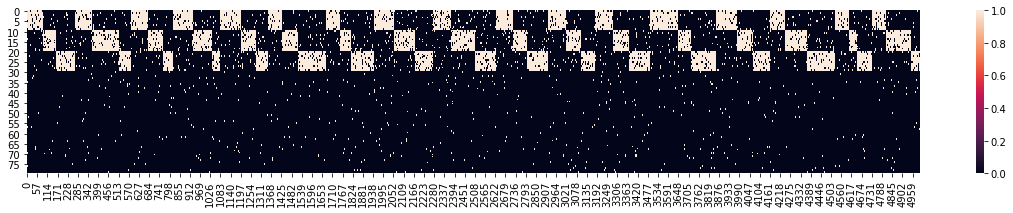

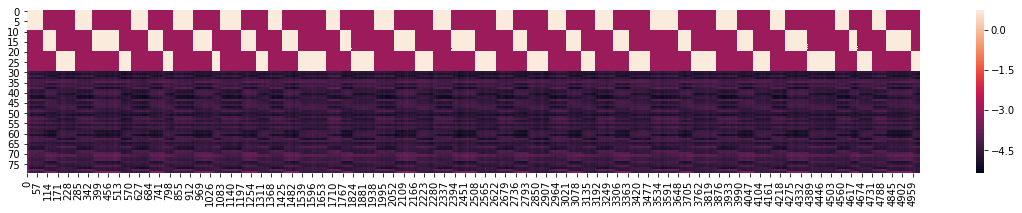

In [152]:
fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(spikes)
plt.title("Spikes")
plt.show()

fig, ax = plt.subplots(figsize=(20, 3))
sns.heatmap(np.log(rho))
plt.title("Firing intensities")
plt.show()